#### - Sobhan Moradian Daghigh
#### - 12/11/2021
#### - ML - EX02 - Q1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns 

In [2]:
dataset = pd.read_csv('./HeartDisease/heart.csv')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
# Independent features: 
indeps = ['sex', 'cp', 'fbs', 'restcg', 'exang', 'slope', 'ca', 'thal']

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


#### Standardization

In [5]:
# scaler = StandardScaler()
# scaler.fit(dataset.iloc[:, :-1])
# scaled_dset = scaler.transform(dataset.iloc[:, :-1])
# scaled_dset = pd.DataFrame(scaled_dset, columns=dataset.columns[:-1])
# scaled_dset['target'] = dataset.iloc[:, -1]
# scaled_dset.head()
scaled_dset = dataset

<AxesSubplot:>

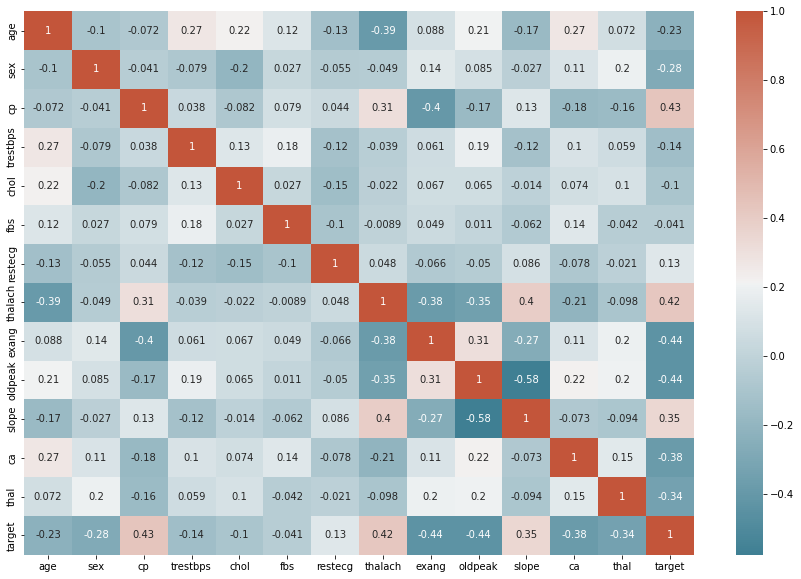

In [6]:
corr = scaled_dset.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### Splite the dataset into 80% of train and 20% of test.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(scaled_dset.iloc[:, :-1], scaled_dset.iloc[:, -1], test_size=0.2)
train = pd.DataFrame(x_train)
train['target'] = y_train
test = pd.DataFrame(x_test)
test['target'] = y_test

#### Naive Bayes

In [8]:
def cal_prior_probabilities(dataset):
    return np.log(dataset.groupby(by = 'target').apply(lambda x: np.divide(len(x), dataset.shape[0]))).values

In [9]:
def return_statistics(dataset):
    mean = dataset.groupby(by='target').apply(lambda x: x.mean(axis=0))
    variance = dataset.groupby(by='target').apply(lambda x: x.var(axis=0))

    return (mean.values, variance.values)

In [10]:
# Continues
def cal_probability_density(mean, variance, x):
    # (1 / np.sqrt(2*np.pi*variance) ) * np.exp( (-(x - mean)**2)  / ( 2*variance ) )
    partA = np.multiply(2, np.multiply(np.pi, variance))
    partB = np.divide(1, np.sqrt(partA))
    partC = np.multiply(-1, np.power(np.subtract(x, mean), 2))
    partD = np.divide(partC, np.multiply(2, variance))
    return np.multiply(partB, np.exp(partD))

In [11]:
# Discrete
def cal_probability(dataset, col, x):
    frequent = dataset.iloc[:, col].value_counts()[x]
    return frequent / dataset.shape[0]

In [12]:
def cal_likelihood_probabilities(df_row, mean, variance, n_unique_labels, n_cols, dataset):
    
    likelihood_probabilities = []
    for i in range(n_unique_labels):
        likelihood = 0
        
        for j in range(n_cols):
            if dataset.columns[j] not in indeps:
                likelihood += np.log(cal_probability_density(mean[i][j], variance[i][j], df_row[j]))
            else:
                likelihood += np.log(cal_probability(dataset, j, df_row[j]))
        likelihood_probabilities.append(likelihood)

    return likelihood_probabilities

In [13]:
def NBC_fit(dataset):

    n_cols = dataset.shape[1] - 1
    unique_labels = dataset['target'].unique()
    n_unique_labels = len(unique_labels)

    mean, variance = return_statistics(dataset)
    prior_probabilities = cal_prior_probabilities(dataset)

    return {
      'n_cols': n_cols,
      'unique_labels': unique_labels,
      'n_unique_labels': n_unique_labels,
      'mean': mean,
      'variance': variance,
      'prior_probabilities': prior_probabilities,
      'dataset': dataset 
    }

In [14]:
def predict(test_dataset, nbc):
    predictions = []
    for i in range(test_dataset.shape[0]):
        prior = nbc['prior_probabilities']
        likelihood = cal_likelihood_probabilities(test_dataset.iloc[i, :-1], nbc['mean'], 
                                                  nbc['variance'], nbc['n_unique_labels'], nbc['n_cols'], nbc['dataset'])
        # log(a*b) = loga + logb
        probabilities = prior + likelihood
        mx_idx = np.argmax(probabilities)
        predictions.append(nbc['unique_labels'][mx_idx])

    return predictions

In [15]:
nbc = NBC_fit(train)
predictions = predict(test, nbc)
accuracy = accuracy_score(test.iloc[:, -1], predictions)
print('accuracy: {:.3f}'.format(accuracy))

accuracy: 0.717


### Part G:

#### Removing 'chol'

In [16]:
train_no_chol = train.drop(['chol'], axis=1)
test_no_chol = test.drop(['chol'], axis=1)

nbc = NBC_fit(train_no_chol)
predictions = predict(test_no_chol, nbc)
accuracy = accuracy_score(test_no_chol.iloc[:, -1], predictions)
print('accuracy: {:.3f}'.format(accuracy))

accuracy: 0.732


#### Removing 'oldpeak'

In [17]:
train_no_oldpeak = train.drop(['oldpeak'], axis=1)
test_no_oldpeak = test.drop(['oldpeak'], axis=1)

nbc = NBC_fit(train_no_oldpeak)
predictions = predict(test_no_oldpeak, nbc)
accuracy = accuracy_score(test_no_oldpeak.iloc[:, -1], predictions)
print('accuracy: {:.3f}'.format(accuracy))

accuracy: 0.712
